<a href="https://colab.research.google.com/github/OptimizationExpert/Pyomo/blob/main/routing_shortest_path_waiting_CP_V3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [63]:
!pip install ortools
from ortools.sat.python import cp_model # CP-SAT solver
import numpy as np
from random import randint
import random
from math import ceil
import pandas as pd
import matplotlib.pyplot as plt # Data visualization
#plt.rcParams["figure.figsize"] = (15,10)

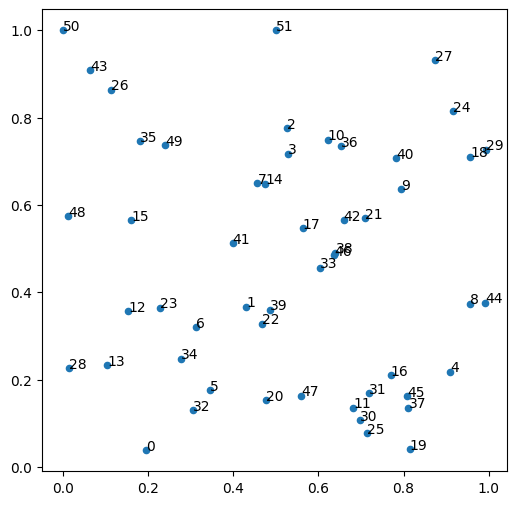

In [64]:
df = pd.DataFrame()

N = 50
m = 2
dest = [N+i for i in range(m)]
destination = {n:random.sample(dest,1)[0] for n in range(N)}

nodes = [n for n in range(N)] + dest
df['X'] = [dest.index(n)/m if n in dest else random.random() for n in nodes]
df['Y'] = [1 if n in dest else random.random() for n in nodes]

def dist(i,j,df):
  x1,y1 = df.loc[i,'X'],df.loc[i,'Y']
  x2,y2 = df.loc[j,'X'],df.loc[j,'Y']
  return int(1000*np.sqrt( (x1-x2)**2 +(y1-y2)**2))

plt.figure(figsize=(6,6))

plt.scatter(df['X'],df['Y'],s=20)
for n in nodes:
  x1,y1 = df.loc[n,'X'],df.loc[n,'Y']
  plt.text(x1,y1, s=str(n))
plt.show()

In [65]:
destination

{0: 50,
 1: 50,
 2: 51,
 3: 51,
 4: 51,
 5: 51,
 6: 50,
 7: 51,
 8: 50,
 9: 51,
 10: 51,
 11: 51,
 12: 50,
 13: 50,
 14: 51,
 15: 50,
 16: 51,
 17: 51,
 18: 51,
 19: 51,
 20: 51,
 21: 50,
 22: 50,
 23: 51,
 24: 51,
 25: 51,
 26: 51,
 27: 50,
 28: 51,
 29: 51,
 30: 50,
 31: 50,
 32: 50,
 33: 51,
 34: 50,
 35: 50,
 36: 51,
 37: 50,
 38: 50,
 39: 50,
 40: 50,
 41: 51,
 42: 51,
 43: 50,
 44: 51,
 45: 50,
 46: 50,
 47: 50,
 48: 50,
 49: 50}

In [66]:
dest

[50, 51]

In [67]:
member = {}
for i,c in destination.items():
  member[c] = member.get(c,[]) + [i]
member

{50: [0,
  1,
  6,
  8,
  12,
  13,
  15,
  21,
  22,
  27,
  30,
  31,
  32,
  34,
  35,
  37,
  38,
  39,
  40,
  43,
  45,
  46,
  47,
  48,
  49],
 51: [2,
  3,
  4,
  5,
  7,
  9,
  10,
  11,
  14,
  16,
  17,
  18,
  19,
  20,
  23,
  24,
  25,
  26,
  28,
  29,
  33,
  36,
  41,
  42,
  44]}

In [74]:
def path_finder():

  model = cp_model.CpModel()
  solver = cp_model.CpSolver()

  U = {(i,j,c):model.NewBoolVar(f"connection_{i}_{j}_{c}") for c in dest
      for i in nodes
      for j in nodes if i!=j and (c==destination.get(i) or i == c) and (c==destination.get(j) or j == c) and i!=c}


  start= {i: model.NewBoolVar(f"start_{i})") for i in nodes if i not in dest}
  arrival= {i: model.NewIntVar(0,5000, f"arrival_{i})") for i in nodes}
  wait= {i: model.NewIntVar(0,90, f"wait_{i})") for i in nodes}

  for c in dest:
    arcs = [(i,j,v) for (i,j,cc),v in U.items() if c==cc]
    arcs += [(c,i,start[i]) for i in member[c]]
    expressions = [start[i] for i in member[c]]
    model.AddExactlyOne(expressions)
    model.AddCircuit(arcs)

  for (i,j,c),v in U.items():
    model.Add(arrival[j] == wait[i]+arrival[i] + dist(i,j,df) ).OnlyEnforceIf(v)


  for c1 in dest:
    for c2 in dest:
      if c1>c2:
        model.Add(arrival[c1]-arrival[c2] <= 10)
        model.Add(arrival[c2]-arrival[c1] <= 10)

  for i in nodes:
    if i not in dest:
      #pass
      model.Add(arrival[i] == 0).OnlyEnforceIf(start[i])
  # Maximize x
  expressions = [v*dist(i,j,df) for (i,j,c),v in U.items() ]
  model.Minimize(sum(expressions))
  solver.parameters.subsolvers[:] = ['core', 'pseudo_costs', 'no_lp']
  solver.parameters.max_time_in_seconds = 90
  solver.parameters.num_search_workers = 8
  solver.Solve(model)
  return solver,U,arrival, start, wait

def visual():
  plt.figure(figsize=(6,6))
  plt.scatter(df['X'],df['Y'],s=20)
  for n in nodes:
    x1,y1 = df.loc[n,'X'],df.loc[n,'Y']
    plt.text(x1,y1, s=str(n))
  KOLORS = ['r','b','gold','grey','g']
  for (i,j,c),v in U.items():
    if solver.Value(v)>0:
      x1,y1 = df.loc[i,'X'],df.loc[i,'Y']
      x2,y2 = df.loc[j,'X'],df.loc[j,'Y']
      plt.plot([x1,x2],[y1,y2], c= KOLORS[c-N],lw= 2)
  plt.show()

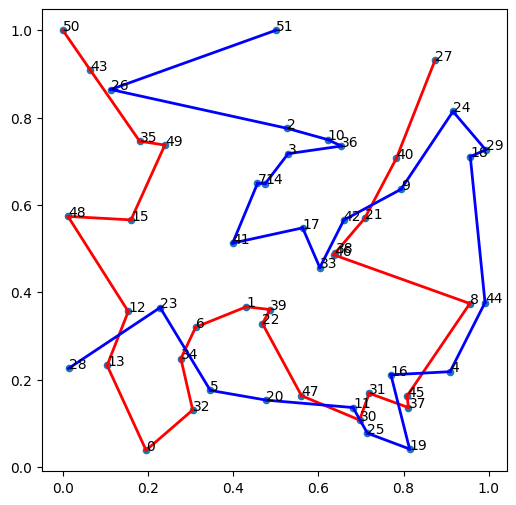

7569
0 2548 90
1 1898 90
2 3667 0
3 3318 90
4 1391 0
5 569 0
6 2115 90
7 3053 90
8 936 0
9 2365 0
10 3568 0
11 905 0
12 3075 90
13 2852 90
14 3161 71
15 3662 0
16 1252 0
17 2737 0
18 1904 0
19 1077 0
20 702 0
21 398 90
22 1717 90
23 346 0
24 2059 90
25 972 0
26 4090 0
27 0 0
28 0 90
29 1943 0
30 1382 0
31 1317 0
32 2405 0
33 2638 0
34 2285 0
35 3999 90
36 3534 0
37 1219 0
38 592 0
39 1843 0
40 242 0
41 2905 0
42 2516 0
43 4288 90
44 1569 0
45 1193 0
46 598 0
47 1529 0
48 3424 90
49 3850 90
50 4490 0
51 4500 0


In [75]:
solver,U,arrival, start, wait = path_finder()
visual()
expressions = [solver.value(v)*dist(i,j,df) for (i,j,c),v in U.items() ]
OF = sum(expressions)
print(OF)
for i in nodes:
  print(i, solver.Value(arrival[i]), solver.Value(wait[i]))

In [ ]:

destination.update({22:20,23:21})
new_update = [22,23]
nodes+=new_update

df2 = pd.DataFrame()
df2['X'] = [dest.index(n)/m if n in dest else random.random() for n in new_update]
df2['Y'] = [1 if n in dest else random.random() for n in new_update]
df2
df3= pd.concat([df,df2], ignore_index=True)
df= df3

df

In [ ]:
solver,U,arrival, start, wait = path_finder()
visual()
expressions = [solver.value(v)*dist(i,j,df) for (i,j,c),v in U.items() ]
OF = sum(expressions)
print(OF)
for i in nodes:
  print(i, solver.Value(arrival[i]), solver.Value(wait[i]))